Process images

In [9]:
import os
from os.path import exists
import pandas as pd
import numpy as np
import cv2

# Import function to extract features
from extract_features import  process_images

#-------------------
# Main script
#-------------------

# Defining paths to metadata, images and their masks
file_data = '..' + os.sep + 'data' + os.sep + 'metadata.csv'
path_image = '..' + os.sep + 'data' + os.sep + 'images' + os.sep + 'images_train'
path_mask = '..' + os.sep + 'data' + os.sep + 'images' + os.sep + 'masks_train'    

# Defining the path to store the features
file_features = 'features/features_original.csv'
feature_names = ['assymetry', 'colours', 'dots and globules', 'compactness']

#Processing images and saving annotations to csv
df_features=process_images(file_data, path_image, path_mask,feature_names)
df_features.to_csv(file_features, index=False)

Train classifier

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB

#from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pickle



metadata_df = pd.read_csv(file_data)

#Merging created annotations with patiend details
combined_df = df_features.merge(metadata_df[['img_id', 'diagnostic', 'patient_id']], left_on='image_id', right_on='img_id', how='left')
if combined_df.isnull().values.any():
    raise ValueError("NaN values detected after merge! Check the data integrity.")

# Preparing the dataset

# X - features evaluation
X = combined_df[feature_names].to_numpy()
# Y - patient diagnistic assuming that 'BCC' , 'MEL' and 'SCC' are cancerous
y = np.logical_or(combined_df['diagnostic'].values == 'BCC', combined_df['diagnostic'].values == 'MEL', combined_df['diagnostic'].values == 'SCC')
patient_id = combined_df['patient_id'].values

# Preparing cross-validation
num_folds = 5
group_kfold = GroupKFold(n_splits=num_folds)

# Initialize classifiers
classifiers = [
    KNeighborsClassifier(1), #classifier 0
    KNeighborsClassifier(5), #classifier 1
    RandomForestClassifier(n_estimators=100, random_state=42), #classifier 2
    GradientBoostingClassifier(n_estimators=100, random_state=42), #classifier 3
    AdaBoostClassifier(n_estimators=100, random_state=42), #classifier 4
    DecisionTreeClassifier(random_state=42), #classifier 5
    make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)), #classifier 6
    make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight='balanced')), #classifier 7
    make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3)), #classifier 8
    GaussianNB() #classifier 9
]

# Initializing accuracy storage
acc_val = np.empty((num_folds, len(classifiers)))
classifier_names = []

# Performing cross-validation
for j, clf in enumerate(classifiers):
    classifier_name = (clf.named_steps['svc'].__class__.__name__ if 'pipeline' in str(clf)
                       else clf.__class__.__name__)
    classifier_names.append(classifier_name)
    fold_accuracies = []
    
    for i, (train_index, val_index) in enumerate(group_kfold.split(X, y, patient_id)):
        x_train, y_train = X[train_index], y[train_index]
        x_val, y_val = X[val_index], y[val_index]
        
        # Fitting and predicting
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_val)
        acc = accuracy_score(y_val, y_pred)
        fold_accuracies.append(acc)
        
        # Saving the classifier after training on this fold
        fold_filename = f'classifier_{j}_fold_{i}.sav'
        pickle.dump(clf, open(fold_filename, 'wb'))
    
    acc_val[:, j] = fold_accuracies

# Calculating average accuracy for each classifier
average_acc = np.mean(acc_val, axis=0)
for idx, acc in enumerate(average_acc):
    print(f'Classifier {idx + 1} ({classifier_names[idx]}): average accuracy={acc:.3f}')

# Saving and evaluating each classifier on the full dataset
eval_results = {}
for idx, clf in enumerate(classifiers):
    classifier_name = classifier_names[idx]
    classifier_filename = f'classifier_{idx}.sav'
    
    # Saving classifier
    pickle.dump(clf, open(classifier_filename, 'wb'))
    
    # Loading classifier
    loaded_clf = pickle.load(open(classifier_filename, 'rb'))
    
    # Predicting on the full dataset and calculating evaluation metrics
    y_pred = loaded_clf.predict(X)
    acc = accuracy_score(y, y_pred)
    clf_report = classification_report(y, y_pred)
    
    eval_results[classifier_name] = {'accuracy': acc, 'report': clf_report}

# Displaying evaluation results
for clf_name, results in eval_results.items():
    print(f"Results for {clf_name}:")
    print(f"Accuracy: {results['accuracy']}")
    #print(f"Classification Report:\n{results['report']}\n")

C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Classifier 1 (KNeighborsClassifier): average accuracy=0.522
Classifier 2 (KNeighborsClassifier): average accuracy=0.551
Classifier 3 (RandomForestClassifier): average accuracy=0.521
Classifier 4 (GradientBoostingClassifier): average accuracy=0.593
Classifier 5 (AdaBoostClassifier): average accuracy=0.593
Classifier 6 (DecisionTreeClassifier): average accuracy=0.537
Classifier 7 (Pipeline): average accuracy=0.587
Classifier 8 (Pipeline): average accuracy=0.527
Classifier 9 (Pipeline): average accuracy=0.535
Classifier 10 (GaussianNB): average accuracy=0.555
Results for KNeighborsClassifier:
Accuracy: 0.6730866700456158
Results for RandomForestClassifier:
Accuracy: 0.8656867714140902
Results for GradientBoostingClassifier:
Accuracy: 0.6614292954891029
Results for AdaBoostClassifier:
Accuracy: 0.6259503294475418
Results for DecisionTreeClassifier:
Accuracy: 0.8707551951343132
Results for Pipeline:
Accuracy: 0.486568677141409
Results for GaussianNB:
Accuracy: 0.5717181956411556


Evaluate classifier

In [11]:
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix
import glob

#Defining path to metadata and testing set
file_data = '..' + os.sep + 'data' + os.sep + 'metadata.csv'
path_image = '..' + os.sep + 'data' + os.sep + 'images' + os.sep + 'images_evaluate'
path_mask = '..' + os.sep + 'data' + os.sep + 'images' + os.sep + 'masks_evaluate'    

#Processing images
features_df = process_images(file_data, path_image, path_mask,feature_names)
feature_names = ['assymetry', 'colours', 'dots and globules', 'compactness']

# Merging features with metadata 
combined_df = features_df.merge(metadata_df[['img_id', 'diagnostic', 'patient_id']], left_on='image_id', right_on='img_id', how='left')

# Preparing the dataset
X = combined_df[feature_names].to_numpy()
y = np.logical_or(combined_df['diagnostic'].values == 'BCC', combined_df['diagnostic'].values == 'MEL', combined_df['diagnostic'].values == 'SCC')

patient_id = combined_df['patient_id']

# Function to load a classifier and evaluate it
def load_and_evaluate(model_filename, X, y):
    try:
        with open(model_filename, 'rb') as model_file:
            classifier = pickle.load(model_file)
        print(f"Loaded classifier from {model_filename}")
    except Exception as e:
        print(f"An error occurred while loading the model from {model_filename}: {e}")
        return None, None

    # Predicting the labels and calculating accuracy and confusion matrix
    pred_labels = classifier.predict(X)
    accuracy = accuracy_score(y, pred_labels)
    cm = confusion_matrix(y, pred_labels)
    
    return accuracy, cm

# List of classifier filenames
classifier_filenames = [f'classifier_{i}.sav' for i in range(len(os.listdir(r"C:\Data Science project files\Classifier\fyp2024")))]

# Evaluate all classifiers
for model_filename in classifier_filenames:
    accuracy, cm = load_and_evaluate(model_filename, X, y)
    print(f"Results for {model_filename}:")
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", cm)


Loaded classifier from classifier_0.sav
Results for classifier_0.sav:
Accuracy: 0.5511811023622047
Confusion Matrix:
 [[44 33]
 [24 26]]
Loaded classifier from classifier_1.sav
Results for classifier_1.sav:
Accuracy: 0.6141732283464567
Confusion Matrix:
 [[56 21]
 [28 22]]
Loaded classifier from classifier_2.sav
Results for classifier_2.sav:
Accuracy: 0.5433070866141733
Confusion Matrix:
 [[46 31]
 [27 23]]
Loaded classifier from classifier_3.sav
Results for classifier_3.sav:
Accuracy: 0.5433070866141733
Confusion Matrix:
 [[61 16]
 [42  8]]
Loaded classifier from classifier_4.sav
Results for classifier_4.sav:
Accuracy: 0.5748031496062992
Confusion Matrix:
 [[62 15]
 [39 11]]
Loaded classifier from classifier_5.sav
Results for classifier_5.sav:
Accuracy: 0.5354330708661418
Confusion Matrix:
 [[49 28]
 [31 19]]
Loaded classifier from classifier_6.sav
Results for classifier_6.sav:
Accuracy: 0.6062992125984252
Confusion Matrix:
 [[77  0]
 [50  0]]
Loaded classifier from classifier_7.sav
R

Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_0.sav


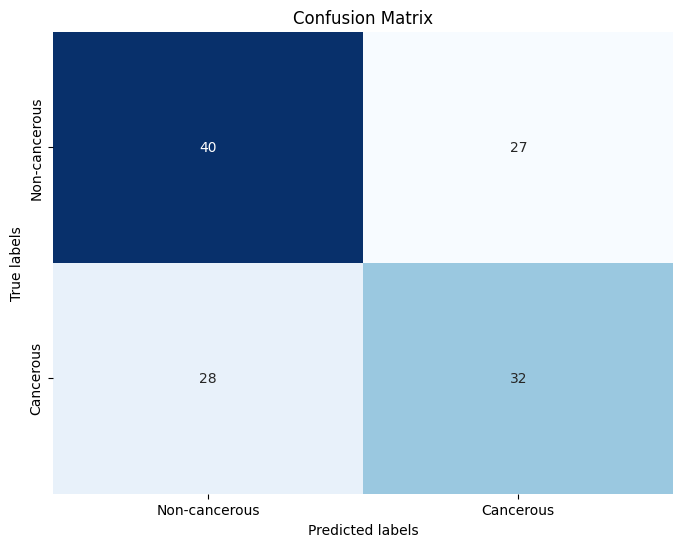

Results for C:\Data Science project files\Classifier\fyp2024\classifier_0.sav:
Accuracy: 0.5669291338582677
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_0_fold_0.sav


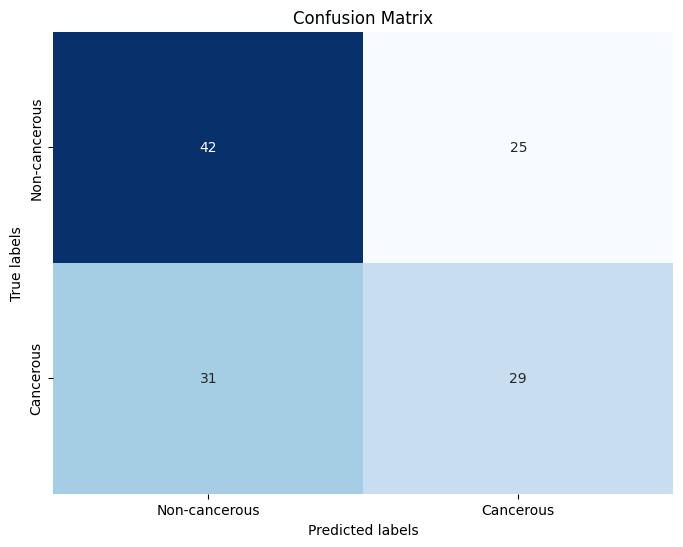

Results for C:\Data Science project files\Classifier\fyp2024\classifier_0_fold_0.sav:
Accuracy: 0.5590551181102362
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_0_fold_1.sav


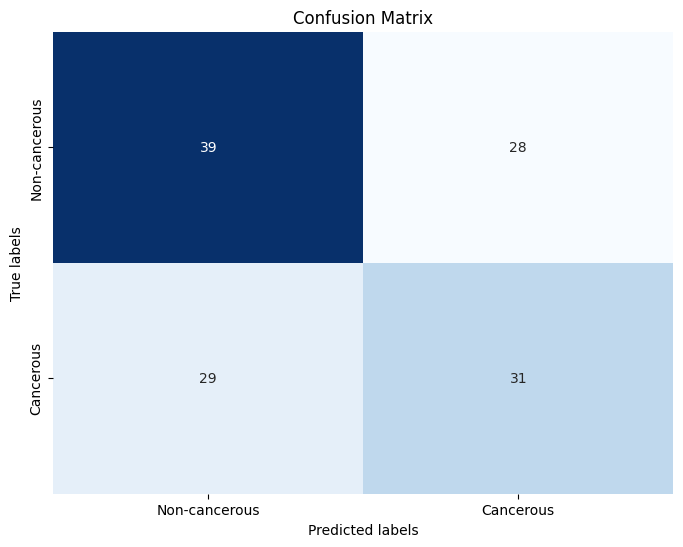

Results for C:\Data Science project files\Classifier\fyp2024\classifier_0_fold_1.sav:
Accuracy: 0.5511811023622047
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_0_fold_2.sav


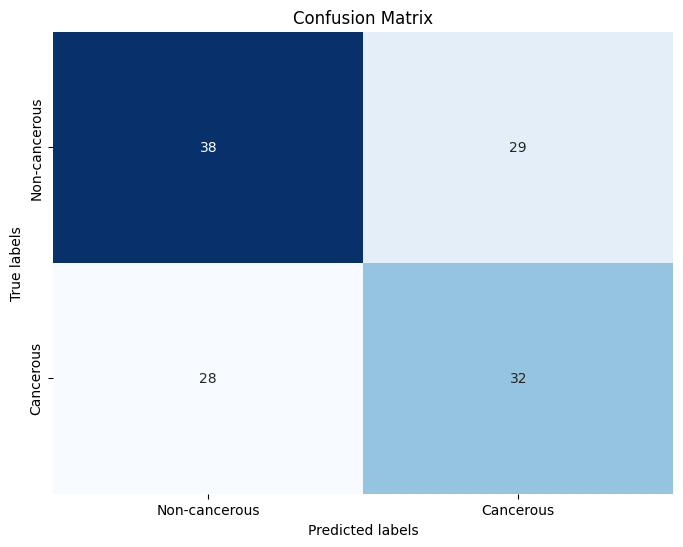

Results for C:\Data Science project files\Classifier\fyp2024\classifier_0_fold_2.sav:
Accuracy: 0.5511811023622047
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_0_fold_3.sav


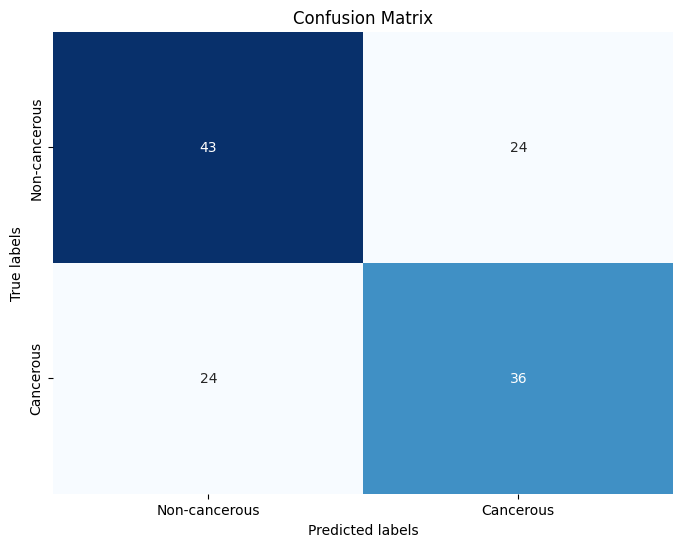

Results for C:\Data Science project files\Classifier\fyp2024\classifier_0_fold_3.sav:
Accuracy: 0.6220472440944882
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_0_fold_4.sav


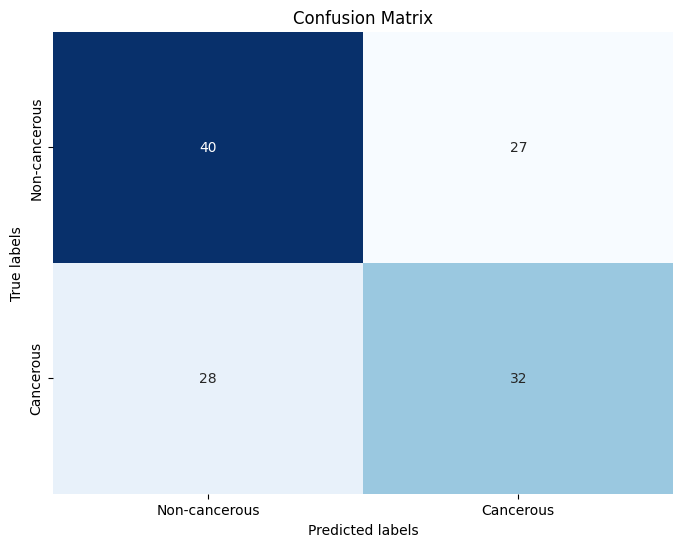

Results for C:\Data Science project files\Classifier\fyp2024\classifier_0_fold_4.sav:
Accuracy: 0.5669291338582677
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_1.sav


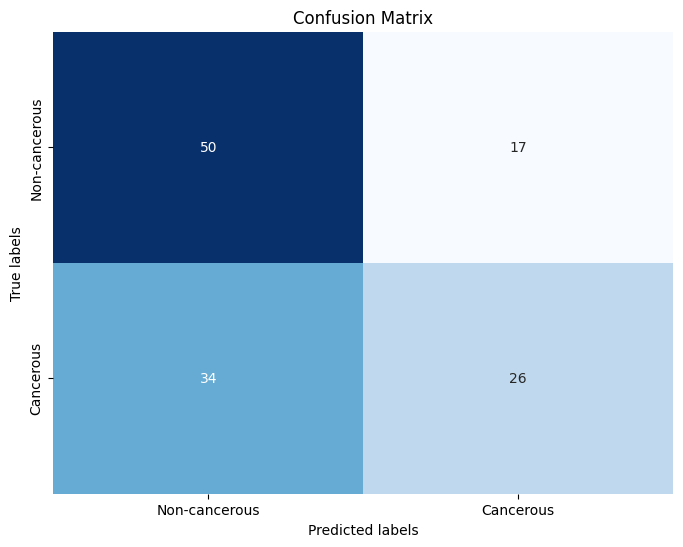

Results for C:\Data Science project files\Classifier\fyp2024\classifier_1.sav:
Accuracy: 0.5984251968503937
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_10.sav


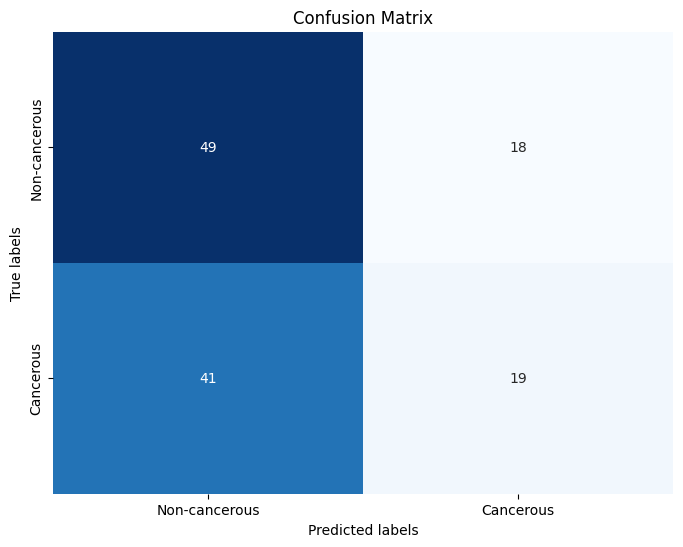

Results for C:\Data Science project files\Classifier\fyp2024\classifier_10.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_10_fold_0.sav


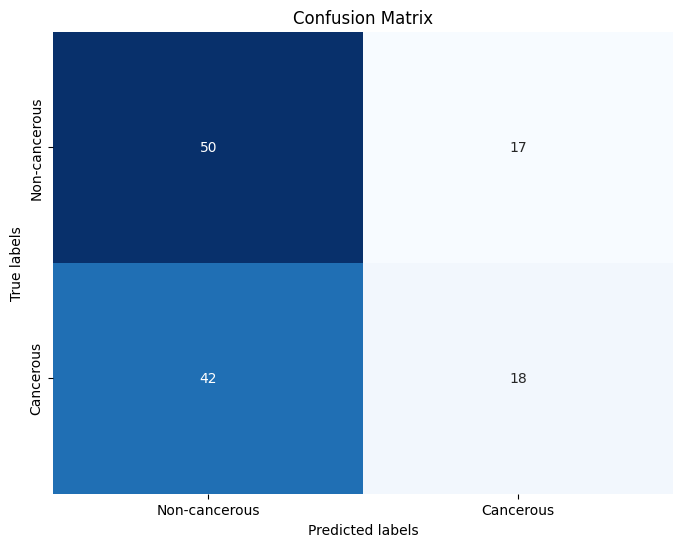

Results for C:\Data Science project files\Classifier\fyp2024\classifier_10_fold_0.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_10_fold_1.sav


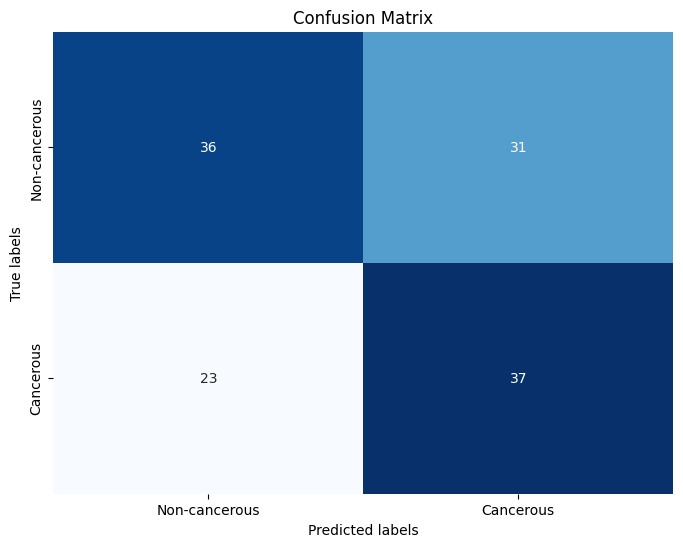

Results for C:\Data Science project files\Classifier\fyp2024\classifier_10_fold_1.sav:
Accuracy: 0.5748031496062992
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_10_fold_2.sav


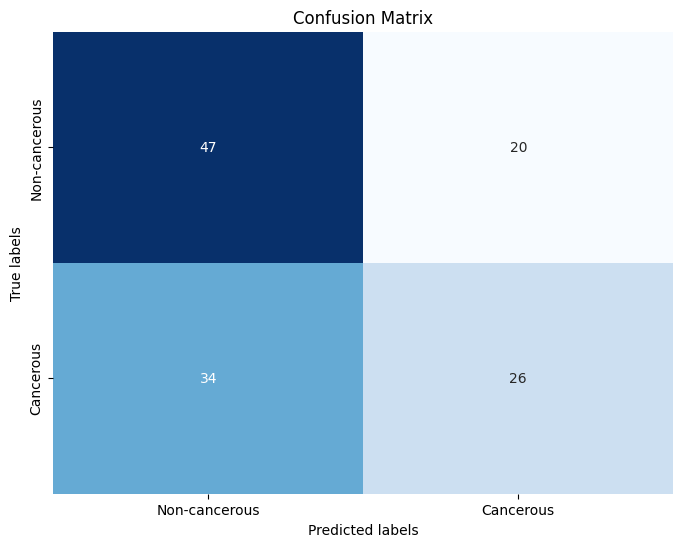

Results for C:\Data Science project files\Classifier\fyp2024\classifier_10_fold_2.sav:
Accuracy: 0.5748031496062992
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_10_fold_3.sav


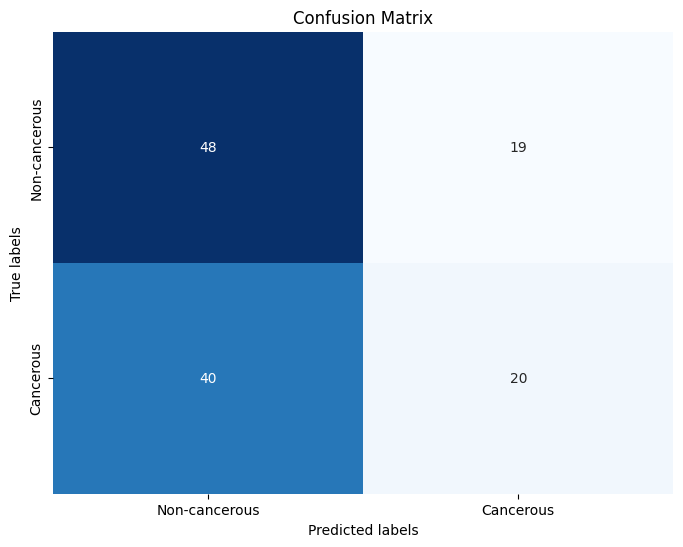

Results for C:\Data Science project files\Classifier\fyp2024\classifier_10_fold_3.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_10_fold_4.sav


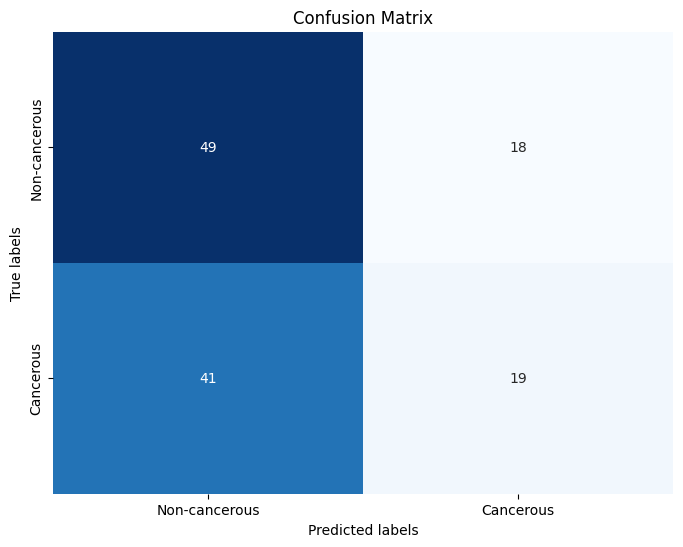

Results for C:\Data Science project files\Classifier\fyp2024\classifier_10_fold_4.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_1_fold_0.sav


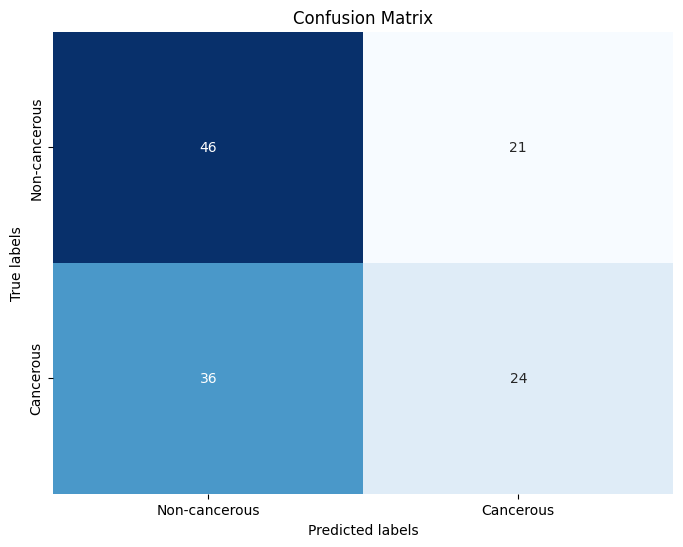

Results for C:\Data Science project files\Classifier\fyp2024\classifier_1_fold_0.sav:
Accuracy: 0.5511811023622047
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_1_fold_1.sav


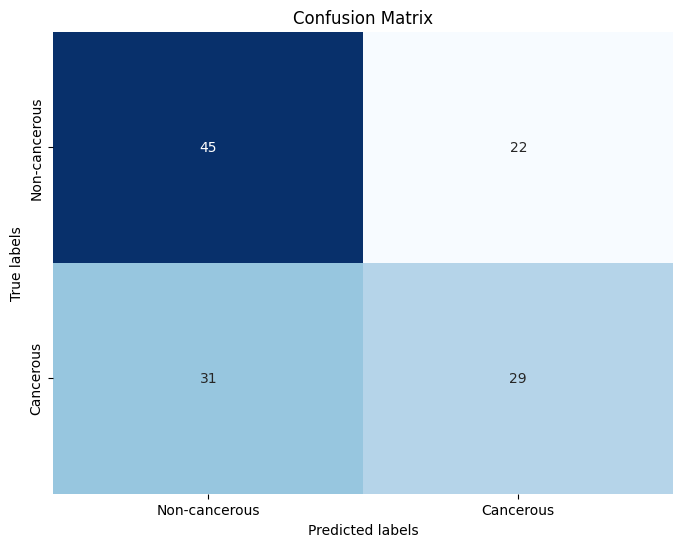

Results for C:\Data Science project files\Classifier\fyp2024\classifier_1_fold_1.sav:
Accuracy: 0.5826771653543307
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_1_fold_2.sav


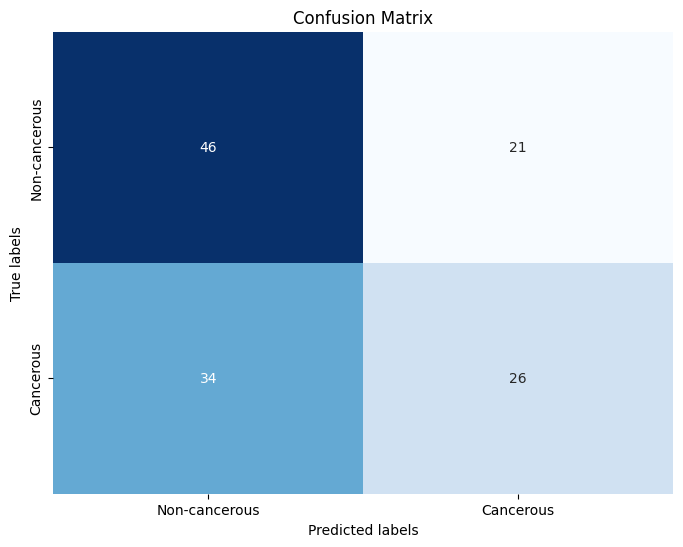

Results for C:\Data Science project files\Classifier\fyp2024\classifier_1_fold_2.sav:
Accuracy: 0.5669291338582677
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_1_fold_3.sav


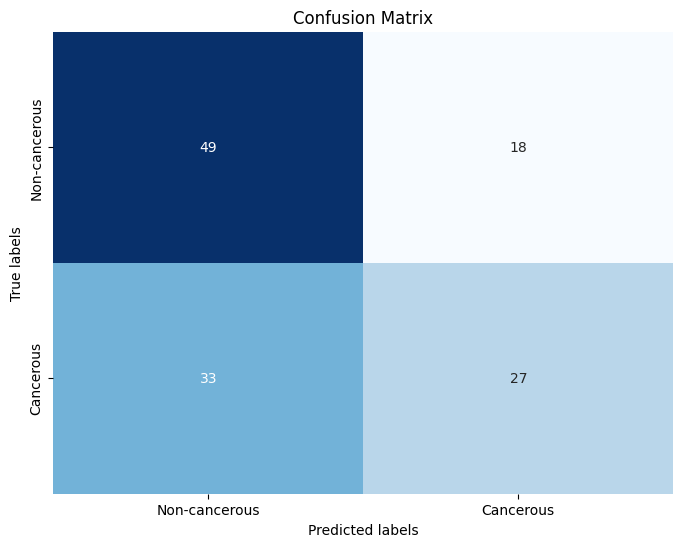

Results for C:\Data Science project files\Classifier\fyp2024\classifier_1_fold_3.sav:
Accuracy: 0.5984251968503937
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_1_fold_4.sav


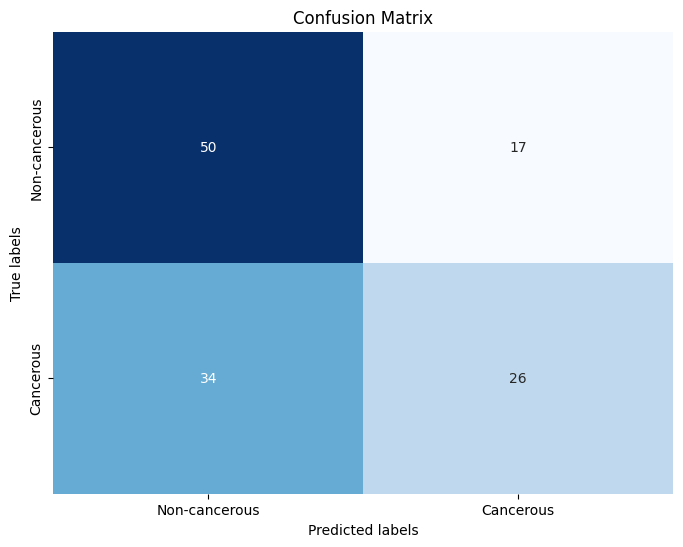

Results for C:\Data Science project files\Classifier\fyp2024\classifier_1_fold_4.sav:
Accuracy: 0.5984251968503937
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_2.sav


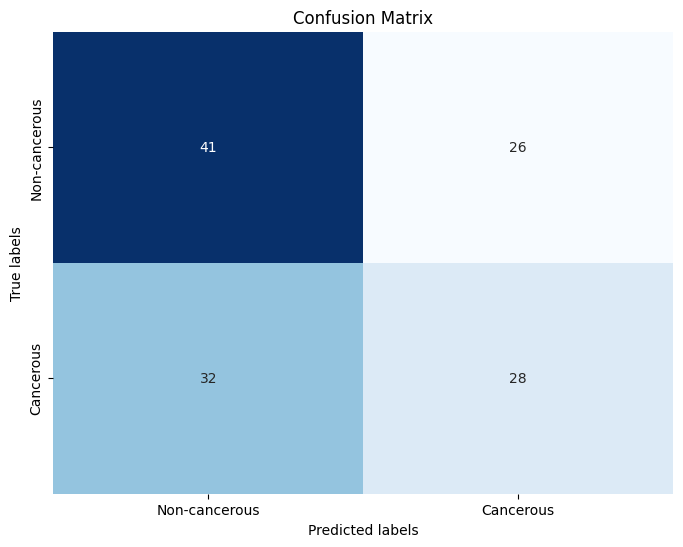

Results for C:\Data Science project files\Classifier\fyp2024\classifier_2.sav:
Accuracy: 0.5433070866141733
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_2_fold_0.sav


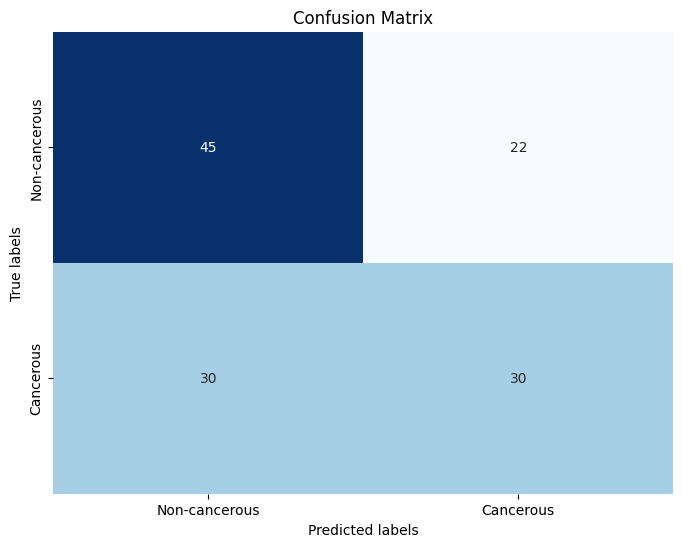

Results for C:\Data Science project files\Classifier\fyp2024\classifier_2_fold_0.sav:
Accuracy: 0.5905511811023622
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_2_fold_1.sav


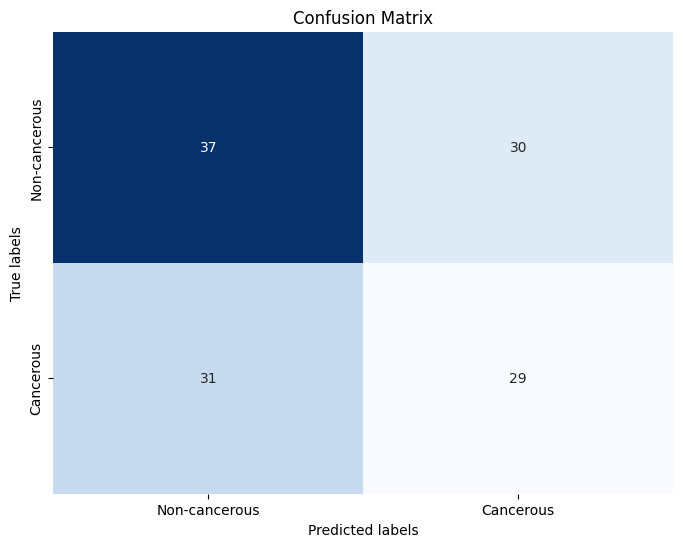

Results for C:\Data Science project files\Classifier\fyp2024\classifier_2_fold_1.sav:
Accuracy: 0.5196850393700787
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_2_fold_2.sav


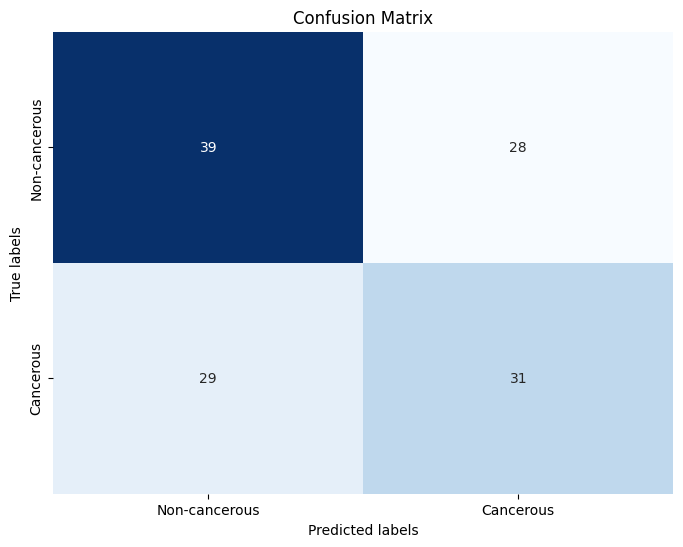

Results for C:\Data Science project files\Classifier\fyp2024\classifier_2_fold_2.sav:
Accuracy: 0.5511811023622047
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_2_fold_3.sav


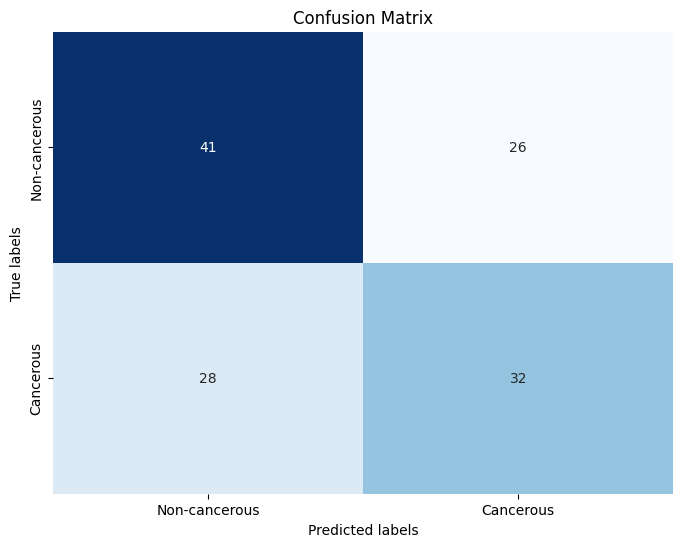

Results for C:\Data Science project files\Classifier\fyp2024\classifier_2_fold_3.sav:
Accuracy: 0.5748031496062992
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_2_fold_4.sav


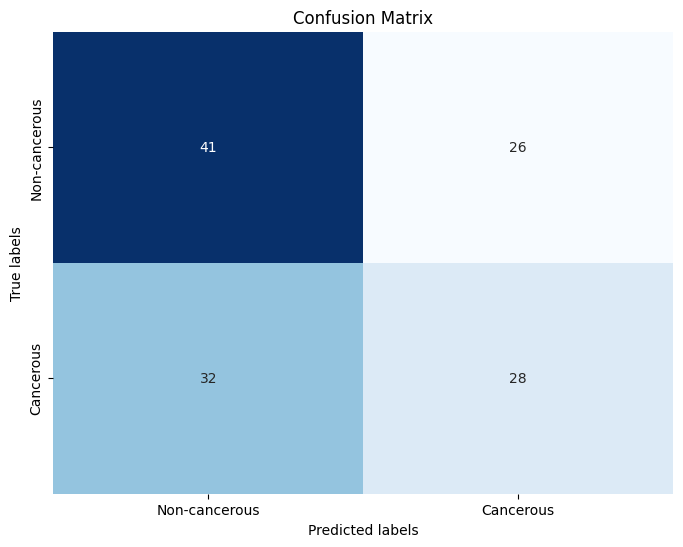

Results for C:\Data Science project files\Classifier\fyp2024\classifier_2_fold_4.sav:
Accuracy: 0.5433070866141733
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_3.sav


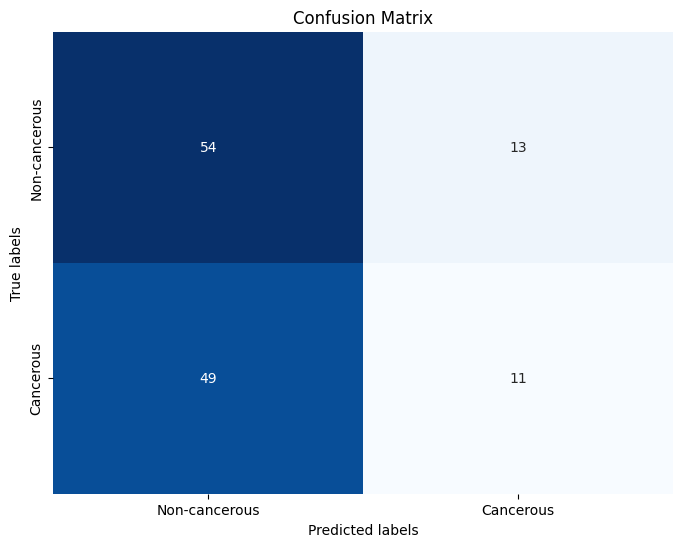

Results for C:\Data Science project files\Classifier\fyp2024\classifier_3.sav:
Accuracy: 0.5118110236220472
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_3_fold_0.sav


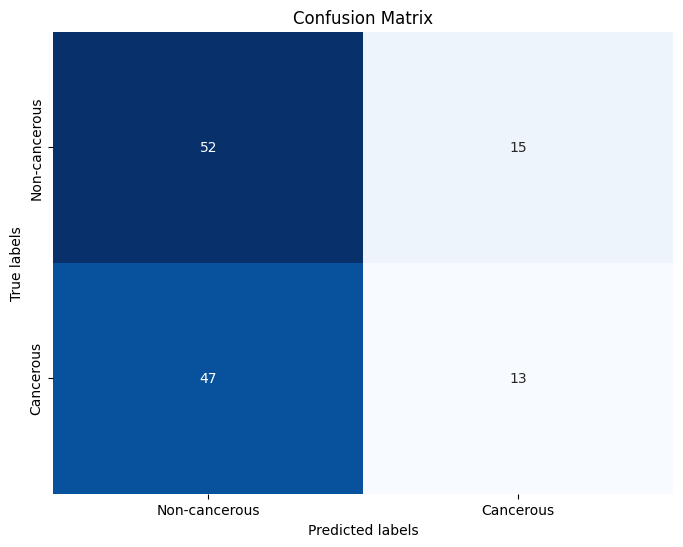

Results for C:\Data Science project files\Classifier\fyp2024\classifier_3_fold_0.sav:
Accuracy: 0.5118110236220472
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_3_fold_1.sav


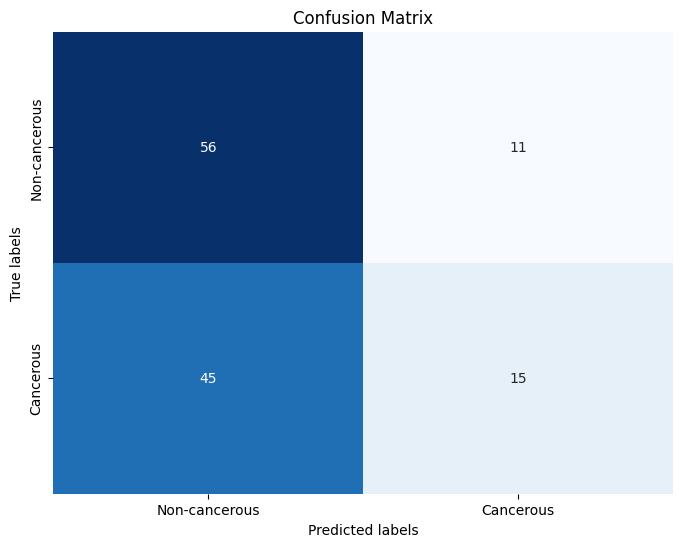

Results for C:\Data Science project files\Classifier\fyp2024\classifier_3_fold_1.sav:
Accuracy: 0.5590551181102362
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_3_fold_2.sav


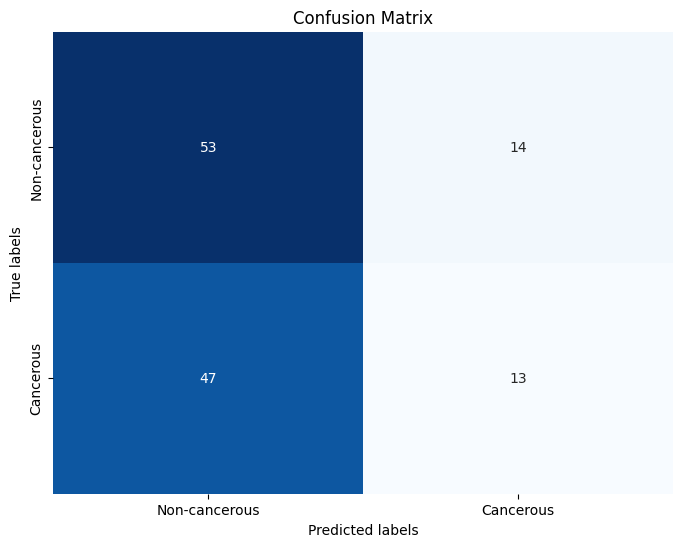

Results for C:\Data Science project files\Classifier\fyp2024\classifier_3_fold_2.sav:
Accuracy: 0.5196850393700787
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_3_fold_3.sav


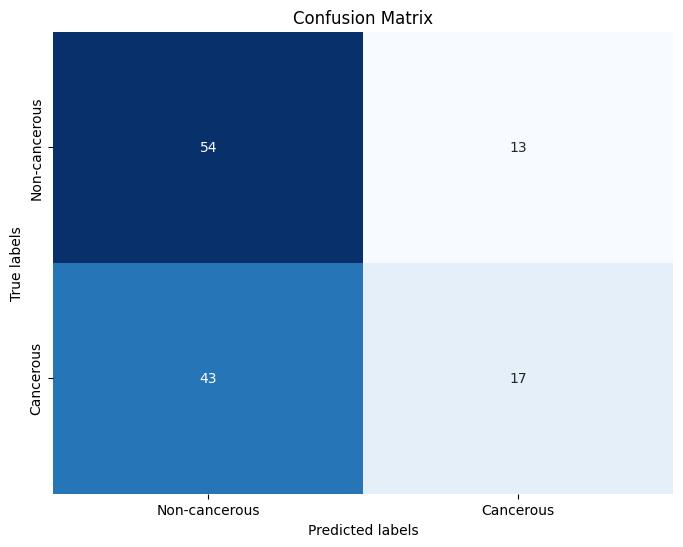

Results for C:\Data Science project files\Classifier\fyp2024\classifier_3_fold_3.sav:
Accuracy: 0.5590551181102362
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_3_fold_4.sav


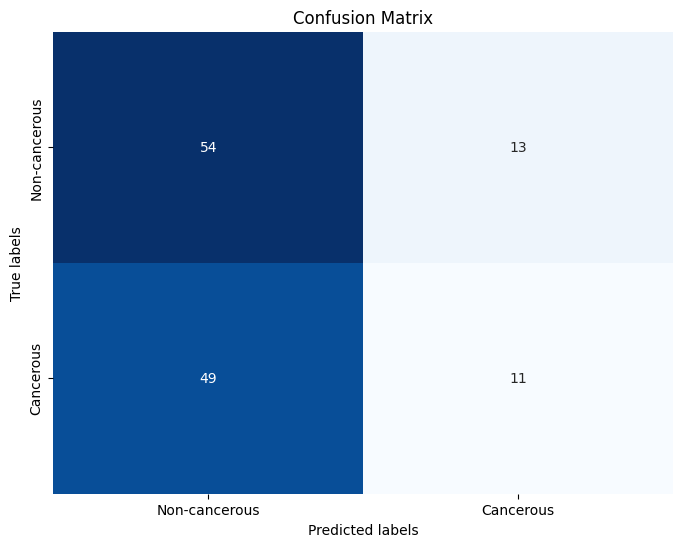

Results for C:\Data Science project files\Classifier\fyp2024\classifier_3_fold_4.sav:
Accuracy: 0.5118110236220472
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_4.sav


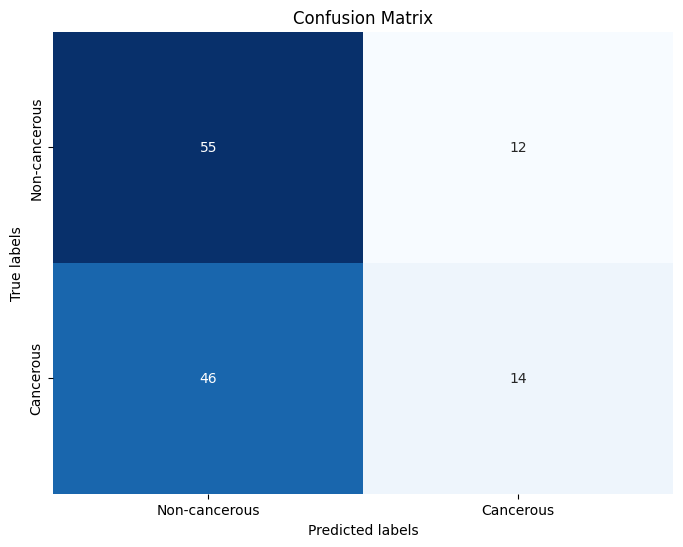

Results for C:\Data Science project files\Classifier\fyp2024\classifier_4.sav:
Accuracy: 0.5433070866141733
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_4_fold_0.sav


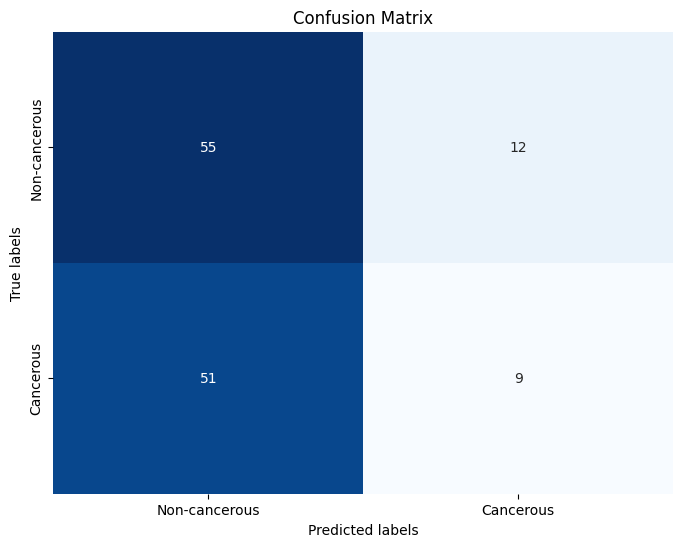

Results for C:\Data Science project files\Classifier\fyp2024\classifier_4_fold_0.sav:
Accuracy: 0.5039370078740157
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_4_fold_1.sav


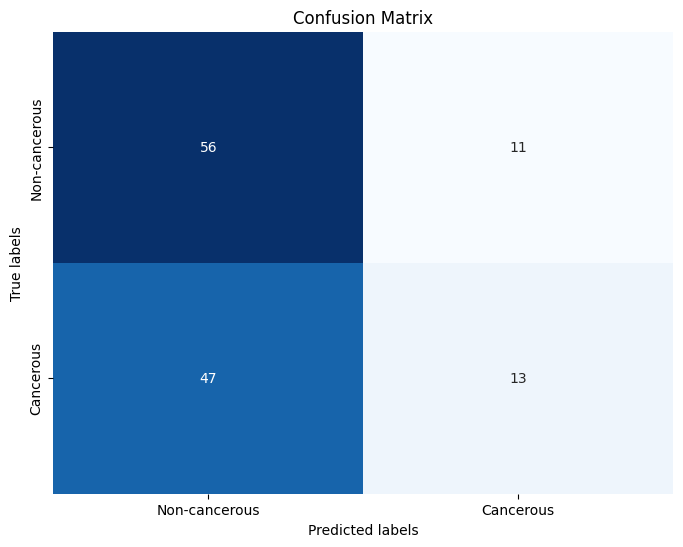

Results for C:\Data Science project files\Classifier\fyp2024\classifier_4_fold_1.sav:
Accuracy: 0.5433070866141733
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_4_fold_2.sav


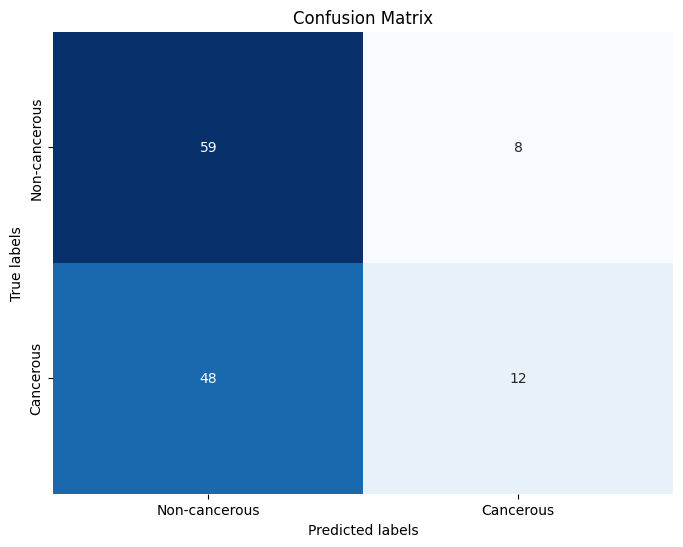

Results for C:\Data Science project files\Classifier\fyp2024\classifier_4_fold_2.sav:
Accuracy: 0.5590551181102362
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_4_fold_3.sav


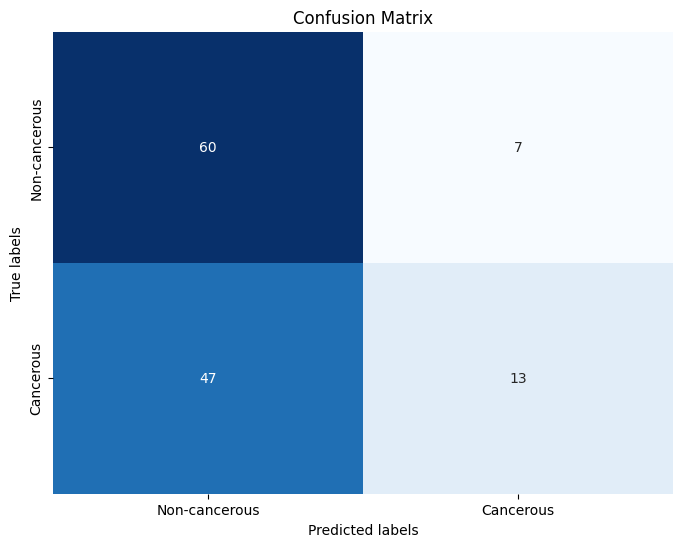

Results for C:\Data Science project files\Classifier\fyp2024\classifier_4_fold_3.sav:
Accuracy: 0.5748031496062992
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_4_fold_4.sav


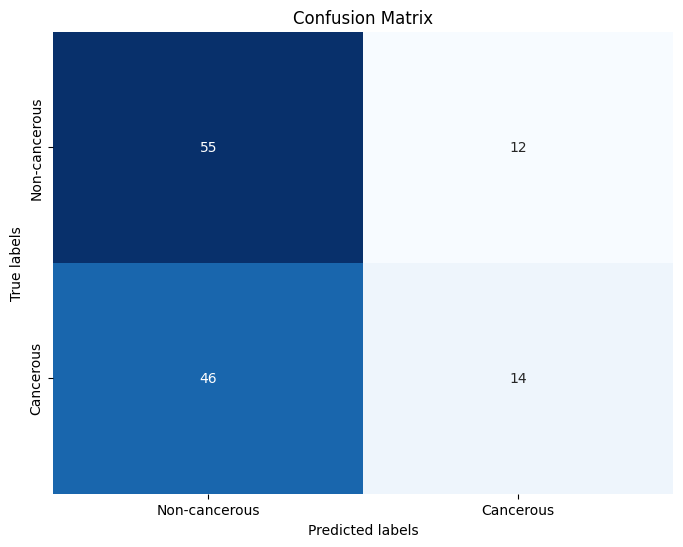

Results for C:\Data Science project files\Classifier\fyp2024\classifier_4_fold_4.sav:
Accuracy: 0.5433070866141733
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_5.sav


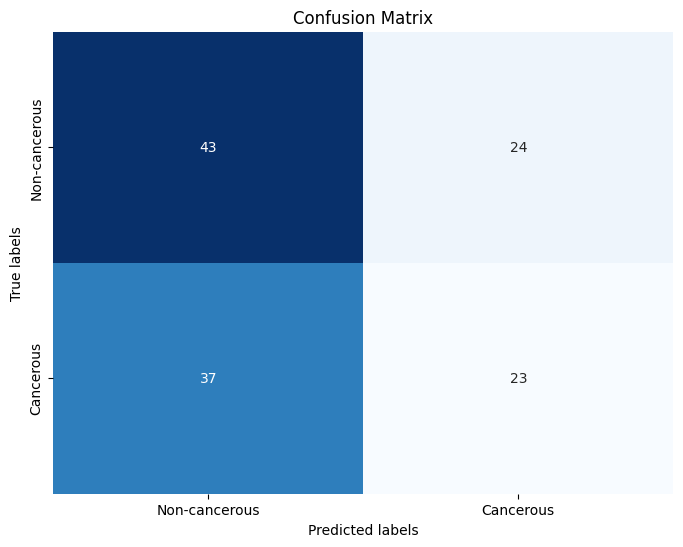

Results for C:\Data Science project files\Classifier\fyp2024\classifier_5.sav:
Accuracy: 0.5196850393700787
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_5_fold_0.sav


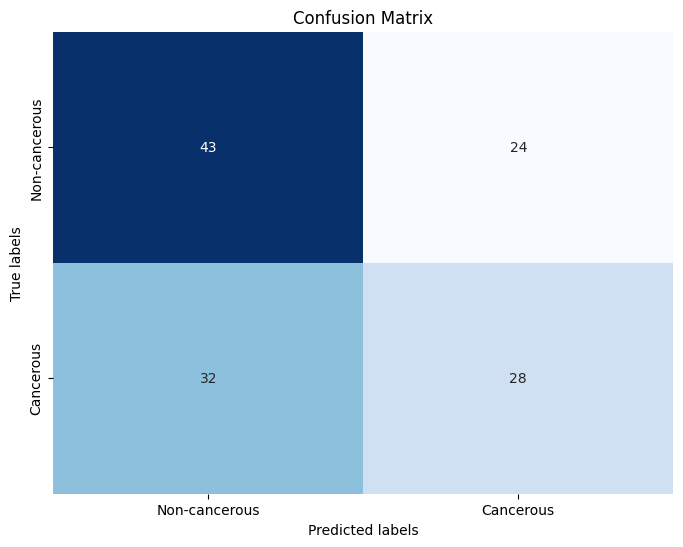

Results for C:\Data Science project files\Classifier\fyp2024\classifier_5_fold_0.sav:
Accuracy: 0.5590551181102362
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_5_fold_1.sav


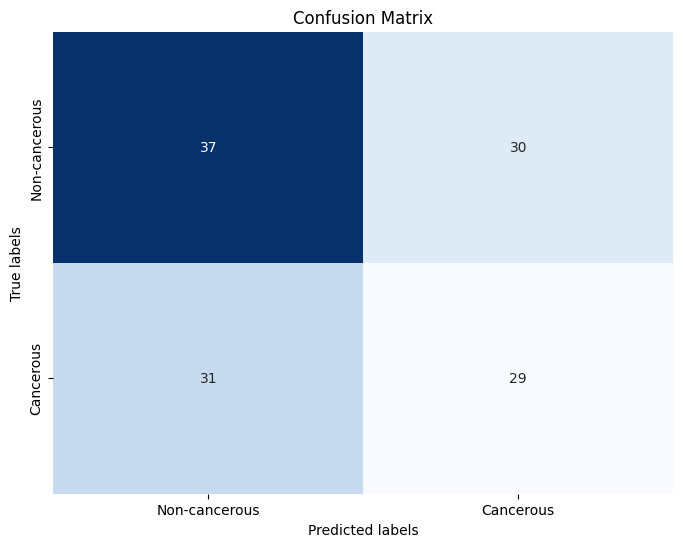

Results for C:\Data Science project files\Classifier\fyp2024\classifier_5_fold_1.sav:
Accuracy: 0.5196850393700787
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_5_fold_2.sav


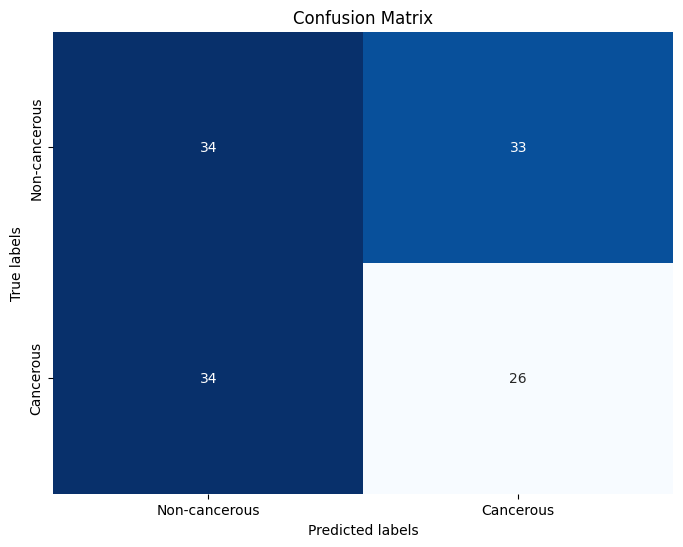

Results for C:\Data Science project files\Classifier\fyp2024\classifier_5_fold_2.sav:
Accuracy: 0.47244094488188976
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_5_fold_3.sav


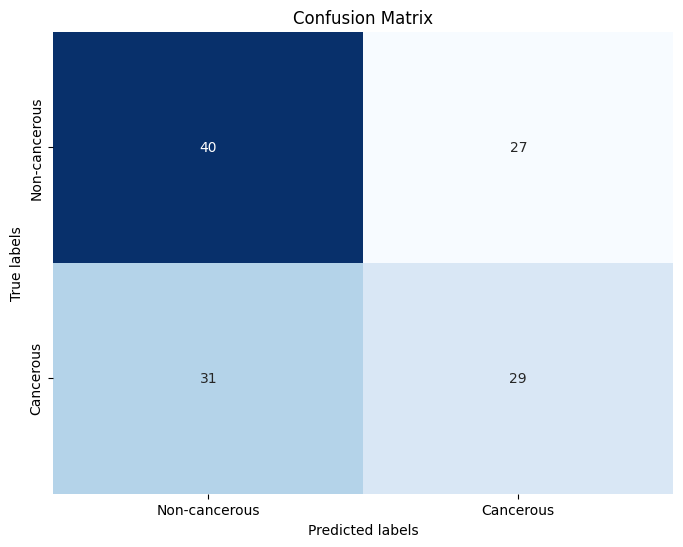

Results for C:\Data Science project files\Classifier\fyp2024\classifier_5_fold_3.sav:
Accuracy: 0.5433070866141733
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_5_fold_4.sav


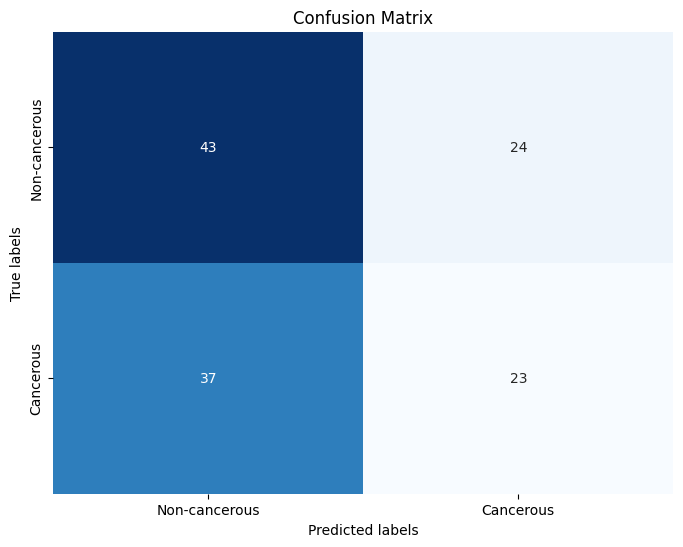

Results for C:\Data Science project files\Classifier\fyp2024\classifier_5_fold_4.sav:
Accuracy: 0.5196850393700787
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_6.sav


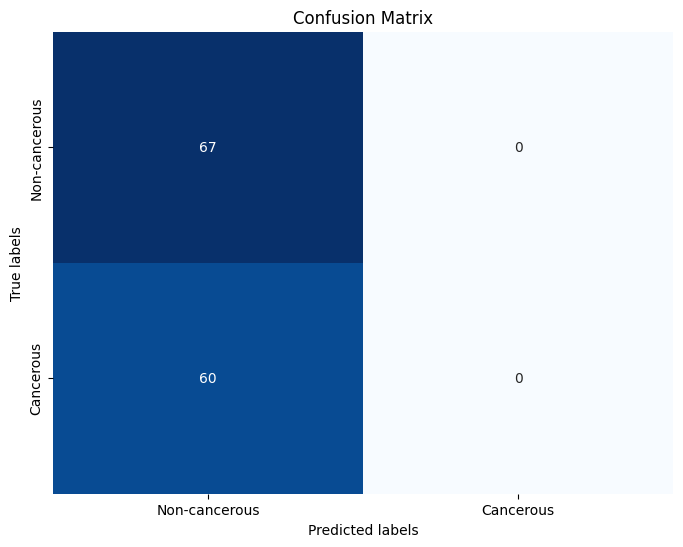

Results for C:\Data Science project files\Classifier\fyp2024\classifier_6.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_6_fold_0.sav


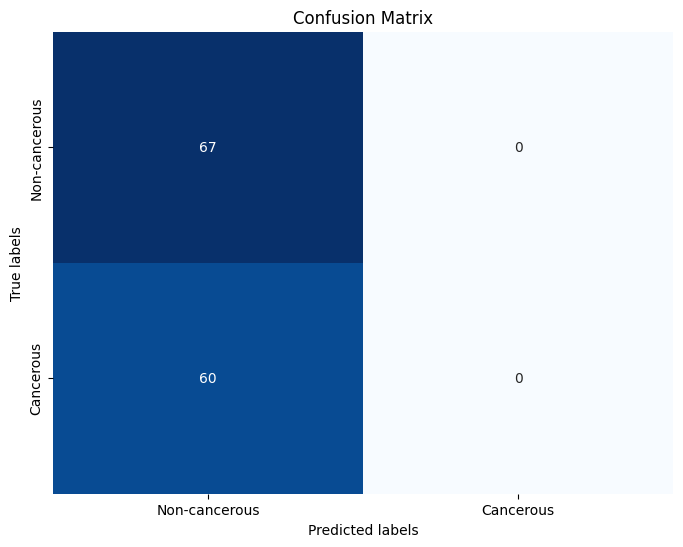

Results for C:\Data Science project files\Classifier\fyp2024\classifier_6_fold_0.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_6_fold_1.sav


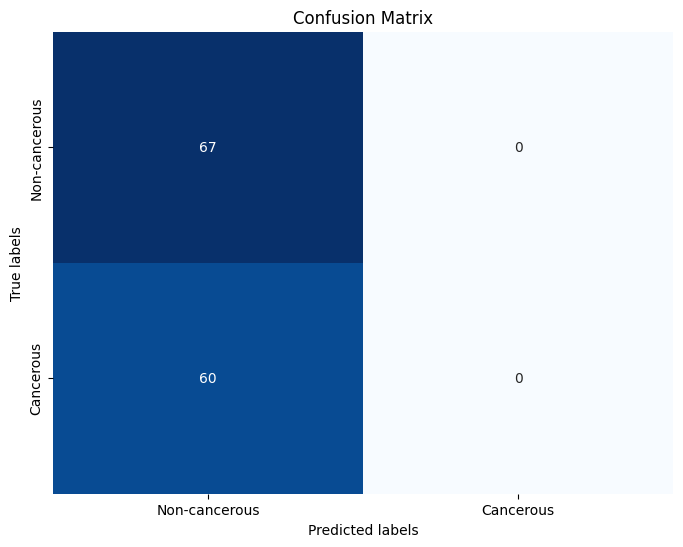

Results for C:\Data Science project files\Classifier\fyp2024\classifier_6_fold_1.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_6_fold_2.sav


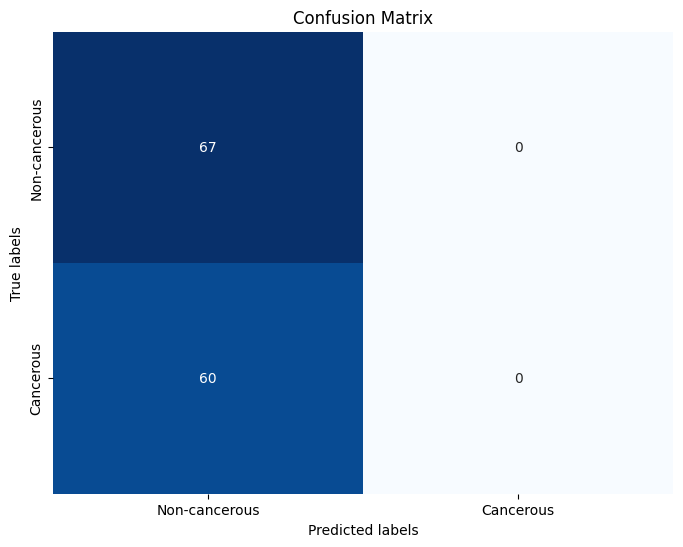

Results for C:\Data Science project files\Classifier\fyp2024\classifier_6_fold_2.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_6_fold_3.sav


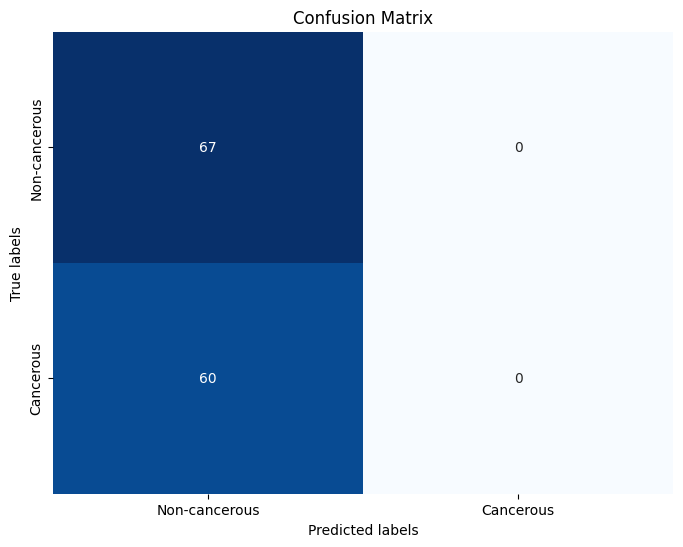

Results for C:\Data Science project files\Classifier\fyp2024\classifier_6_fold_3.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_6_fold_4.sav


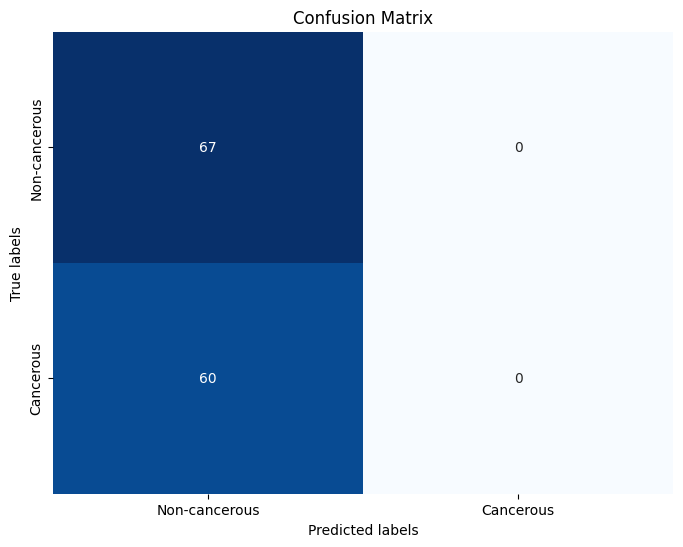

Results for C:\Data Science project files\Classifier\fyp2024\classifier_6_fold_4.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_7.sav


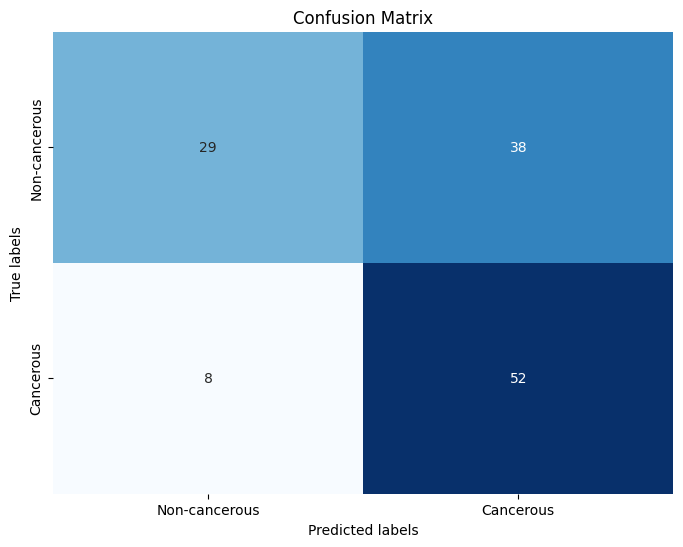

Results for C:\Data Science project files\Classifier\fyp2024\classifier_7.sav:
Accuracy: 0.6377952755905512
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_7_fold_0.sav


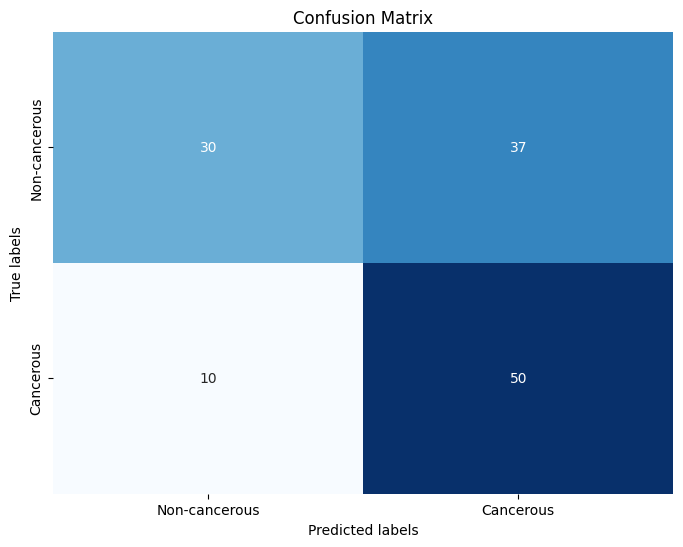

Results for C:\Data Science project files\Classifier\fyp2024\classifier_7_fold_0.sav:
Accuracy: 0.6299212598425197
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_7_fold_1.sav


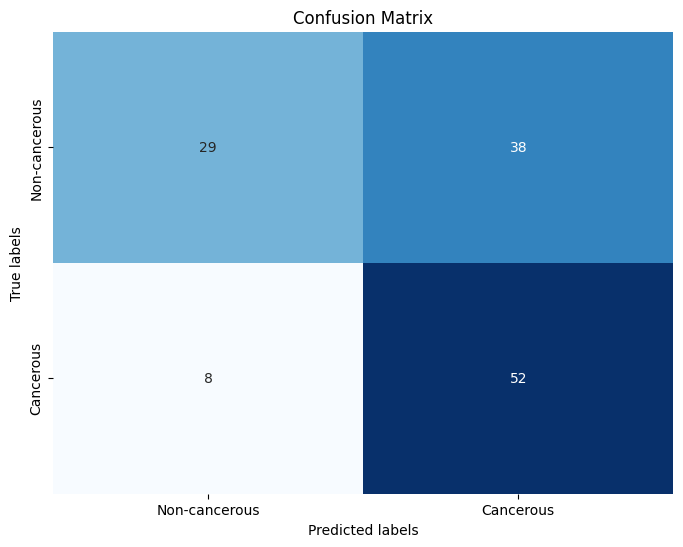

Results for C:\Data Science project files\Classifier\fyp2024\classifier_7_fold_1.sav:
Accuracy: 0.6377952755905512
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_7_fold_2.sav


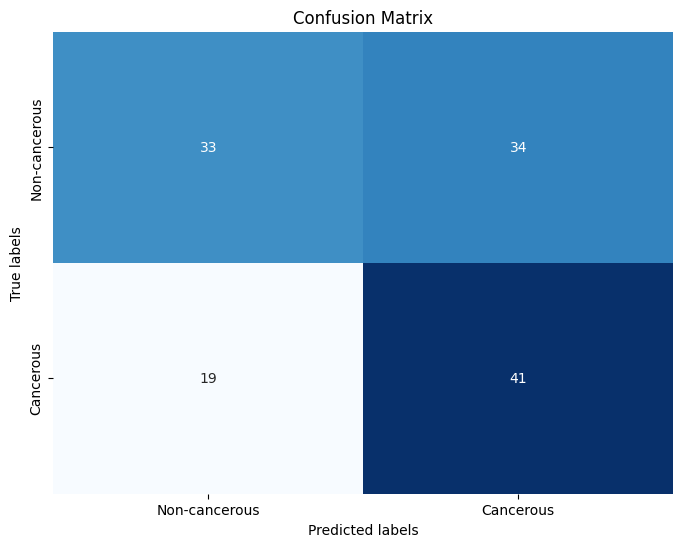

Results for C:\Data Science project files\Classifier\fyp2024\classifier_7_fold_2.sav:
Accuracy: 0.5826771653543307
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_7_fold_3.sav


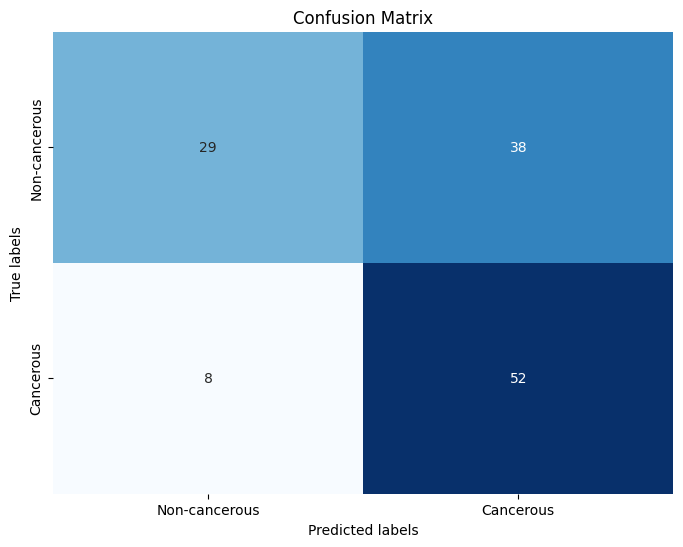

Results for C:\Data Science project files\Classifier\fyp2024\classifier_7_fold_3.sav:
Accuracy: 0.6377952755905512
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_7_fold_4.sav


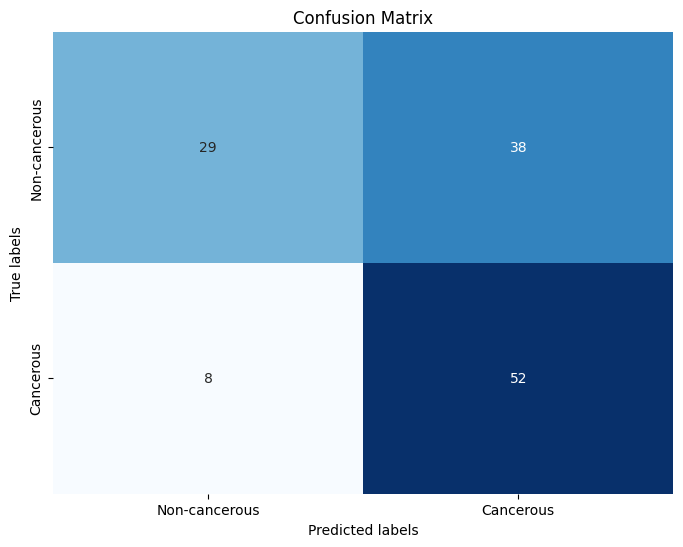

Results for C:\Data Science project files\Classifier\fyp2024\classifier_7_fold_4.sav:
Accuracy: 0.6377952755905512
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_8.sav


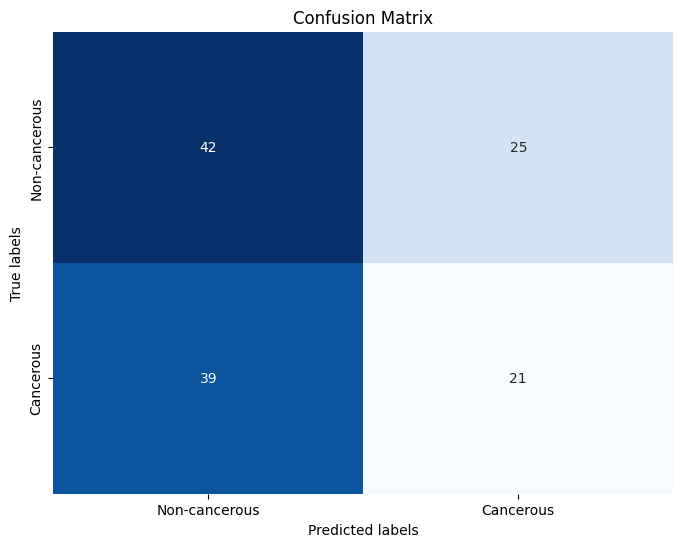

Results for C:\Data Science project files\Classifier\fyp2024\classifier_8.sav:
Accuracy: 0.49606299212598426
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_8_fold_0.sav


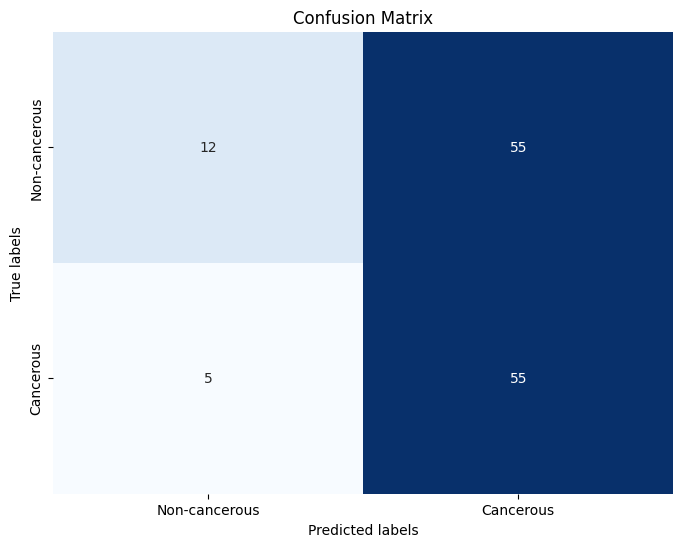

Results for C:\Data Science project files\Classifier\fyp2024\classifier_8_fold_0.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_8_fold_1.sav


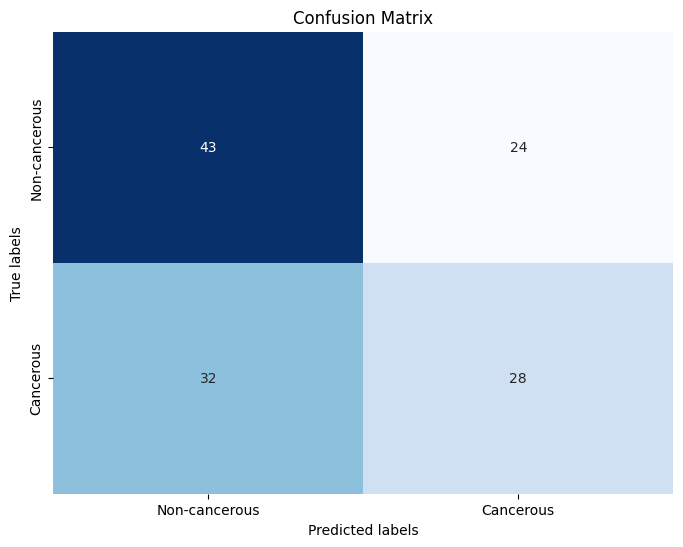

Results for C:\Data Science project files\Classifier\fyp2024\classifier_8_fold_1.sav:
Accuracy: 0.5590551181102362
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_8_fold_2.sav


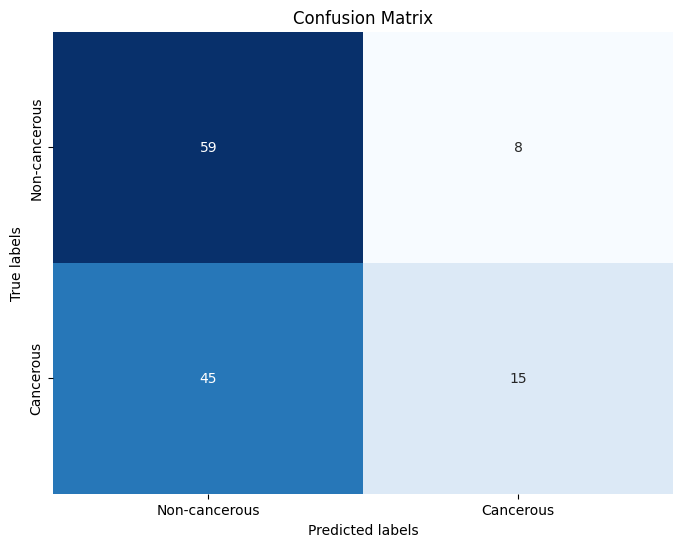

Results for C:\Data Science project files\Classifier\fyp2024\classifier_8_fold_2.sav:
Accuracy: 0.5826771653543307
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_8_fold_3.sav


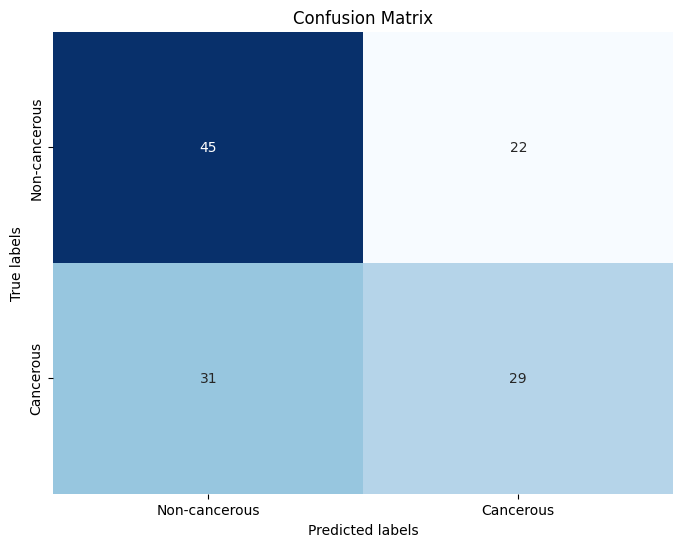

Results for C:\Data Science project files\Classifier\fyp2024\classifier_8_fold_3.sav:
Accuracy: 0.5826771653543307
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_8_fold_4.sav


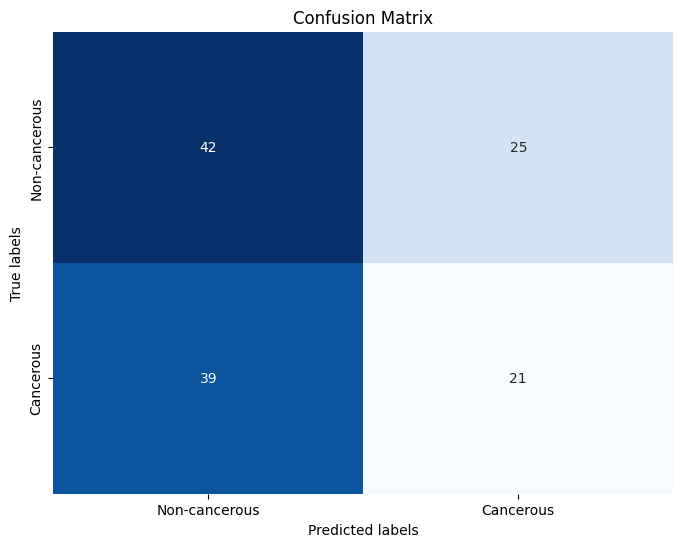

Results for C:\Data Science project files\Classifier\fyp2024\classifier_8_fold_4.sav:
Accuracy: 0.49606299212598426
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_9.sav


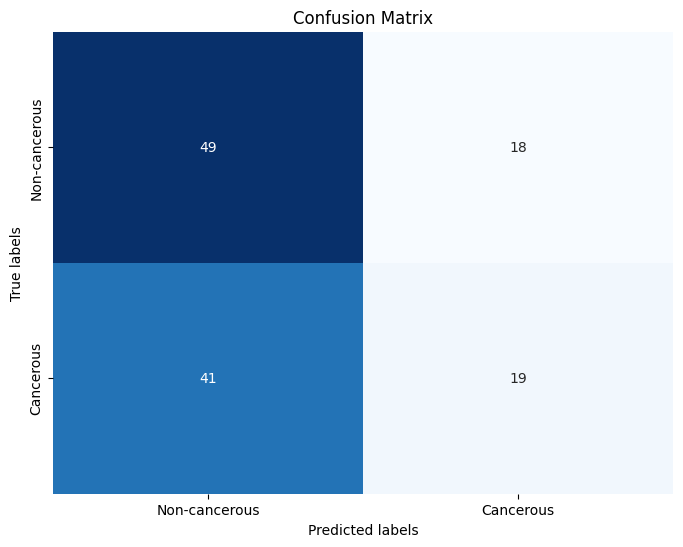

Results for C:\Data Science project files\Classifier\fyp2024\classifier_9.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_9_fold_0.sav


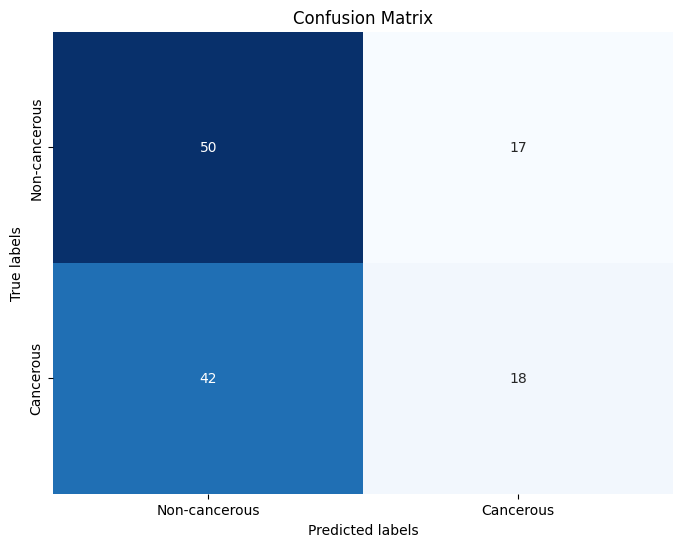

Results for C:\Data Science project files\Classifier\fyp2024\classifier_9_fold_0.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_9_fold_1.sav


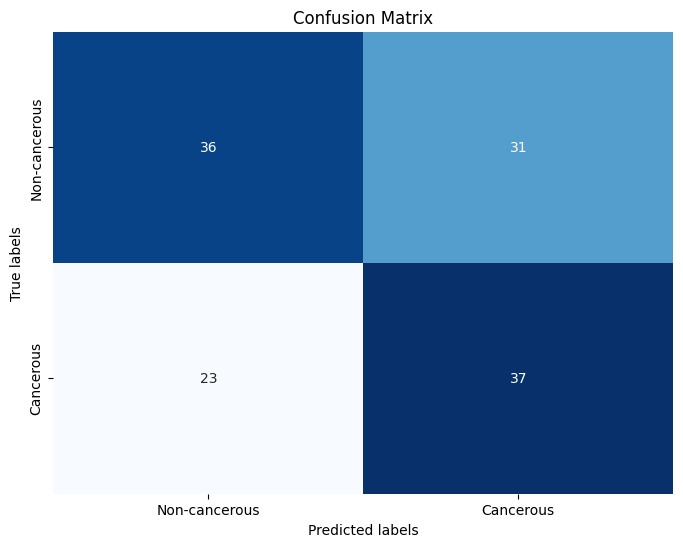

Results for C:\Data Science project files\Classifier\fyp2024\classifier_9_fold_1.sav:
Accuracy: 0.5748031496062992
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_9_fold_2.sav


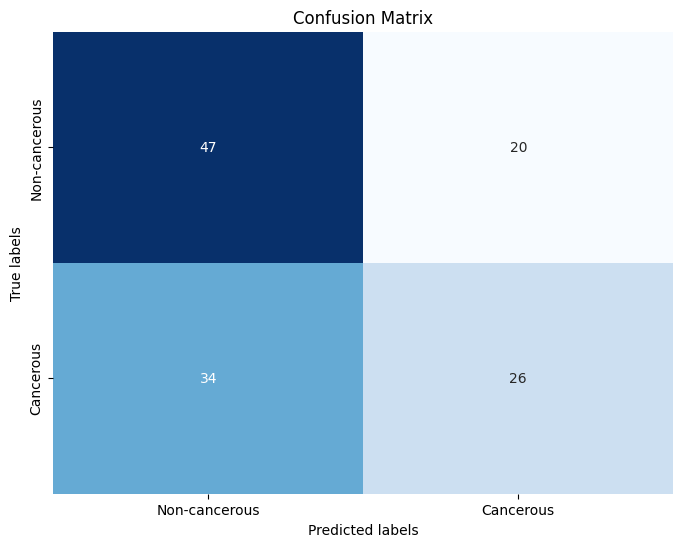

Results for C:\Data Science project files\Classifier\fyp2024\classifier_9_fold_2.sav:
Accuracy: 0.5748031496062992
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_9_fold_3.sav


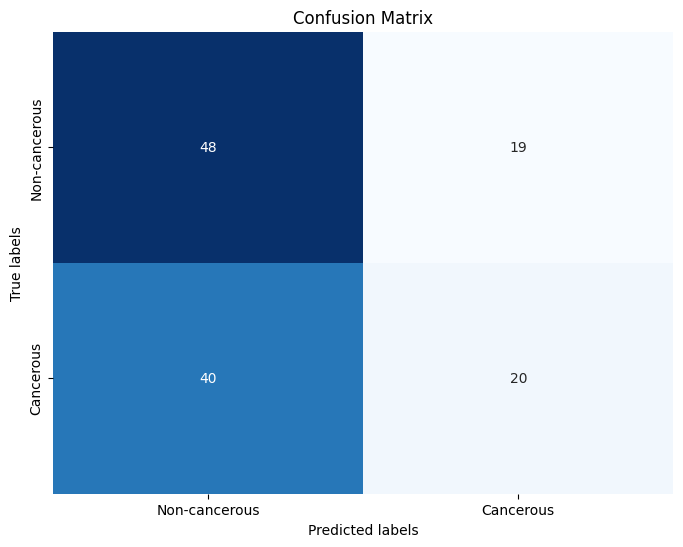

Results for C:\Data Science project files\Classifier\fyp2024\classifier_9_fold_3.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\classifier_9_fold_4.sav


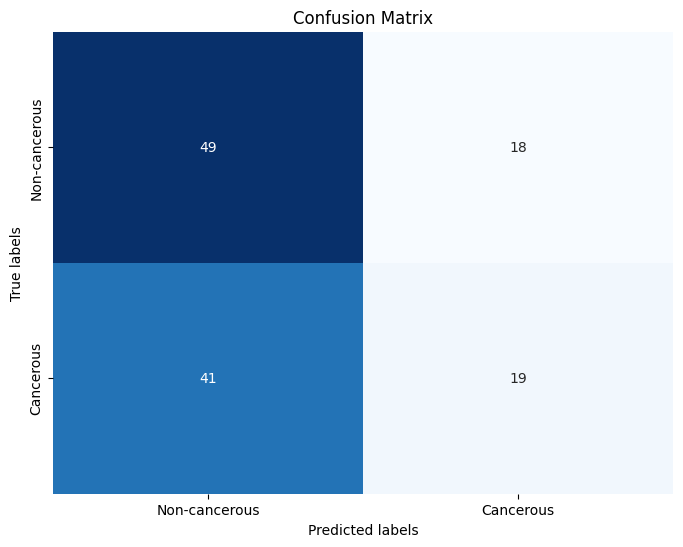

Results for C:\Data Science project files\Classifier\fyp2024\classifier_9_fold_4.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Data Science project files\Classifier\fyp2024\groupXY_classifier.sav


C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: X has 4 features, but KNeighborsClassifier is expecting 3 features as input.

In [13]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import glob
import matplotlib.pyplot as plt
import seaborn as sns

#Defining path to metadata and testing set
data_dir = os.path.join('..', 'data')
features_path = os.path.join(data_dir, 'metadata.csv')
path_image = os.path.join(data_dir, 'images', 'images_evaluate')
path_mask = os.path.join(data_dir, 'images', 'masks_evaluate')

feature_names = ['assymetry', 'colours', 'dots and globules', 'compactness']
features_df = process_images(features_path, path_image, path_mask, feature_names)

# Loading metadata
metadata_df = pd.read_csv(features_path)
combined_df = features_df.merge(metadata_df[['img_id', 'diagnostic', 'patient_id']], left_on='image_id', right_on='img_id', how='left')

# Defining the target variable 'y' where '1' represents cancerous conditions and '0' represents non-cancerous conditions
cancerous_conditions = ['BCC', 'MEL', 'SCC']
combined_df['target'] = combined_df['diagnostic'].apply(lambda x: 1 if x in cancerous_conditions else 0)
y = combined_df['target'].values
X = combined_df[feature_names].values
patient_id = combined_df['patient_id']

def load_and_evaluate(model_filename, X, y):
    try:
        with open(model_filename, 'rb') as model_file:
            classifier = pickle.load(model_file)
        print(f"Loaded classifier from {model_filename}")
    except Exception as e:
        print(f"An error occurred while loading the model from {model_filename}: {e}")
        return None, None

    pred_labels = classifier.predict(X)
    accuracy = accuracy_score(y, pred_labels)
    cm = confusion_matrix(y, pred_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=['Non-cancerous', 'Cancerous'],
                yticklabels=['Non-cancerous', 'Cancerous'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return accuracy, cm

# Using glob to find all classifier files
classifier_dir = r"C:\Data Science project files\Classifier\fyp2024"
classifier_filenames = glob.glob(os.path.join(classifier_dir, '*.sav'))

# Evaluating all classifiers
for model_filename in classifier_filenames:
    accuracy, cm = load_and_evaluate(model_filename, X, y)
    if accuracy is not None:
        print(f"Results for {model_filename}:")
        print("Accuracy:", accuracy)



In [14]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from extract_features import  process_images

data_dir = os.path.join('..', 'data')
features_path = os.path.join(data_dir, 'metadata.csv')
path_image = os.path.join(data_dir, 'images', 'images_original')
path_mask = os.path.join(data_dir, 'images', 'masks_original')

#Define features to use in classification
feature_names = ['assymetry', 'colours', 'dots and globules', 'compactness']
features_df = process_images(features_path, path_image, path_mask, feature_names)

# Load metadata
metadata_df = pd.read_csv(features_path)
combined_df = features_df.merge(metadata_df[['img_id', 'diagnostic', 'patient_id']], left_on='image_id', right_on='img_id', how='left')

# Define the target variable 'y' where '1' represents cancerous conditions and '0' represents non-cancerous conditions
cancerous_conditions = ['BCC', 'MEL', 'SCC']
combined_df['target'] = combined_df['diagnostic'].apply(lambda x: 1 if x in cancerous_conditions else 0)

# Load model and predict probabilities
def predict_probabilities(model_filename, X):
    try:
        with open(model_filename, 'rb') as model_file:
            classifier = pickle.load(model_file)
        print(f"Loaded classifier from {model_filename}")
        probabilities = classifier.predict_proba(X)
        return probabilities
    except Exception as e:
        print(f"An error occurred while loading the model: {e}")
        return None

#Define pass to the model 
model_filename = r"classifier_7.sav"


# Create a list to save probabilities with patient id and labels
results = []

probabilities = predict_probabilities(model_filename, features_df[feature_names].values)
if probabilities is not None:
    # Iterate over each prediction and corresponding image ID
    for idx, prob in enumerate(probabilities):
        results.append({
            'Patient ID': combined_df.iloc[idx]['patient_id'],
            'Image ID': features_df.iloc[idx]['image_id'],
            'Probability Non-cancerous': prob[0],  # Assuming 0 is non-cancerous
            'Probability Cancerous': prob[1],     # Assuming 1 is cancerous
            'Actual Label': combined_df.iloc[idx]['target']  # Ensure target column exists
        })

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Define the Excel writer and the path for the Excel file
excel_path = 'predictions_new.xlsx'


# Write DataFrame to an Excel file
results_df.to_excel(excel_path, index=False)


print(f"Predictions have been saved to {excel_path}")


Loaded classifier from classifier_7.sav
An error occurred while loading the model: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by StandardScaler.
Predictions have been saved to predictions_new.xlsx
